# Despacho económico

**Cotribución de**: Uriel Sandoval, basado en las notas del Prof. Claudio Fuerte.

El despacho económico (DE) es un problema de optimización que busca minimizar el costo de producción de energía eléctrica sujeto a restricciones físicas en la red de potencia. En su modificación más básica, es un problema lineal (LP) o cuadrático (QO) que se soluciona considerando una carga agregada y un pronóstico de energía variable (eólica o solar) para un sólo momento infinitésimal. Matemáticamente, el problema puede ser escrito de la siguiente forma:

\begin{equation*}
\min \sum_{i=1}^N C_i (P_{G_i}) = \sum_{i=1}^N \left(a_i + b_i P_{G_i} + c P_{G_i}^2\right)
\end{equation*}

donde $a_{i}$ es el costo fijo de producción ($\$/MWh$), $b_i$  el costo incremental ($\$/MWh$), $c_i$ es el costo cuadrático de producción ($\$/MWh$) y $P_{G_i}$ es la potencia generada (MW) del generador $i$.


Sujeto a la siguiente restricción:

* Balance de potencia

\begin{equation}
\sum_{i=1}^N P_{G_i} = P_D
\end{equation}

donde $P_D$ es la carga demandada.

Esta formulación no toma en cuenta las pérdidas en la red de transmisión ni las restricciones de flujo en la misma. También notar que efecto de la potencia reactiva no es tomado en cuenta.

## Ejemplo de tres generadores



Considere el siguiente sistema de potencia ideal:

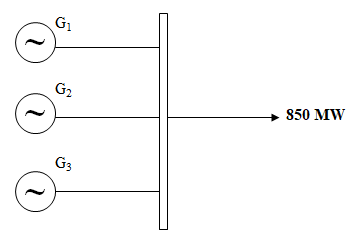


con los siguientes costos de generación.

| Unidad  | $a_i$ | $b_i$ | $c_i$ |
| -- | -- | -- | -- | 
| $G_1$  | 561 | 7.92 | 0.00154 |
| $G_2$ | 310  | 7.8 | 0.002 |
| $G_3$| 78  | 8 | 0.005 |


Por lo cual, nuestro problema de optimización cuadrático se puede escribir como:

\begin{equation}
\min C_T = 561 + 7.92 P_{G_1}  + 0.00154 P_{G_1}^2 + 310 + 7.8 P_{G_2}  + 0.002 P_{G_2}^2 + 78 + 8 P_{G_3}  + 0.005 P_{G_3}^2
\end{equation}

sujeto a:

\begin{equation}
P_{G_1} + P_{G_2} + P_{G_3} = 850
\end{equation}


Este problema de optimización puede ser resuelto utilizando la ecuación extendida de Lagrange:


\begin{equation}
\begin{split}
L  &= C_T + \lambda \left(-\left(P_{G_1} + P_{G_2} + P_{G_3} \right) + 850 \right) \\
&=  561 + 7.92 P_{G_1}  + 0.00154 P_{G_1}^2 + 310 + 7.8 P_{G_2}  + 0.002 P_{G_2}^2 + 78 + 8 P_{G_3}  + 0.005 P_{G_3}^2 +  \lambda \left(- \left(P_{G_1} + P_{G_2} + P_{G_3}\right)  + 850 \right)
\end{split}
\end{equation}

Dado que esta ecuación es continua y convexa se puede calcular el óptimo global derivando $L$ con respecto al resto de las variables e igualando a cero:


$$
\begin{align}
\frac{\partial L}{\partial P_{G_1}} &= 7.92 + 2\left(0.00154 P_{G_1}\right)  - \lambda = 7.92 + 0.00308 P_{G_1} - \lambda = 0 \\ 
\frac{\partial L}{\partial P_{G_2}} &= 7.8 + 2\left(0.002 P_{G_2}\right)  - \lambda = 7.8 + 0.004 P_{G_2} - \lambda  = 0 \\
\frac{\partial L}{\partial P_{G_3}} &= 8.0 + 2\left(0.005 P_{G_3}\right)  - \lambda = 8 + 0.01 P_{G_3} - \lambda  = 0 \\
\frac{\partial L}{\partial \lambda} &= -P_{G_1} - P_{G_2} - P_{G_3} + 850 = 0 
\end{align}
$$


Como se puede notar, las derivadas forman un sistema de 4 ecuaciones lineales con 4 variables, el cual puede ser resuelto fácilmente utilizando Julia (o Matlab, etc):


\begin{equation}
\begin{bmatrix}
0.00308 & 0 & 0 & -1 \\
0 & 0.004 & 0 & -1 \\
0 & 0 & 0.01 & -1 \\
-1 &-1 &-1 & 0
\end{bmatrix}
\begin{bmatrix}
P_{G_1} \\
P_{G_2} \\
P_{G_2} \\
\lambda
\end{bmatrix} = 
\begin{bmatrix}
-7.92 \\
-7.8 \\
-8 \\
-850
\end{bmatrix}
\end{equation}

In [1]:
using LinearAlgebra;

In [2]:
A = [2*0.00154 0 0 -1; 
    0 2*0.002 0 -1;
    0 0 2*0.005 -1;
    -1 -1 -1 0]

4×4 Array{Float64,2}:
  0.00308   0.0     0.0   -1.0
  0.0       0.004   0.0   -1.0
  0.0       0.0     0.01  -1.0
 -1.0      -1.0    -1.0    0.0

In [3]:
b = [-7.92;-7.8; -8; -850]

4-element Array{Float64,1}:
   -7.92
   -7.8
   -8.0
 -850.0

In [4]:
x = A\b

4-element Array{Float64,1}:
 398.4600577478343
 336.81424446583264
 114.72569778633303
   9.14725697786333

Por lo cual la solución a este problema es:

\begin{equation*}
P_{G_1} = 398.46\\
P_{G_2} = 336.8142\\
P_{G_3} = 114.7256\\
\lambda = 9.1472
\end{equation*}


$\lambda$ es conocido como el costo marginal. 

Ahora podemos resolver este sistema utilizando JuMP y el solver OSQP. 




In [5]:
# Importamos JuMP y OSQP
using JuMP, OSQP

In [6]:
a = [561, 310, 78];
b = [7.92, 7.8, 8];
c = [0.00154, 0.002, 0.005];
Pd = 850.;
n = 3;


# Definimos el modelo
ed = Model(OSQP.Optimizer)

# Agregamos las variables
@variable(ed,p_g[1:n]);

#Define the objective funciton
@objective(ed, Min, sum(a[i] + b[i]*p_g[i] + c[i]*p_g[i]^2 for i in 1:n));

# Power balance constraint
@constraint(ed, balance,  sum(p_g[i] for i in 1:n) == Pd);

optimize!(ed)


println("\n")
println("Despacho de generación: ", value.(p_g), " MW")
println("Lambda  = ", dual(balance), "\$/MW")
println("\n")
println("Costo de generación: ", objective_value(ed), "\$")




Despacho de generación: [398.46005845189234, 336.8142450274407, 114.72569802814812] MW
Lambda  = 9.14724781979021$/MW


Costo de generación: 8186.964402624736$
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 3, constraints m = 1
          nnz(P) + nnz(A) = 6
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2571e+

Podemos extender el problema de optimización y considerar los siguientes límites de generación:

| Unidad  | $P_{G_i}^{\min}$ | $P_{G_i}^{\max}$ |
| -- | -- | -- |
| $G_1$  | 150 | 600 | 
| $G_2$ | 100  | 400 | 
| $G_3$| 50 | 200 |

Por lo cual el problema deberá ser formulado de la siguiente forma:

\begin{equation*}
\min \sum_{i=1}^N C_i (P_{G_i}) = \sum_{i=1}^N \left(a_i + b_i P_{G_i} + c P_{G_i}^2\right)
\end{equation*}

sujeto a:

* Ecuación de balance de potencia:

$$
\sum_{i=1}^N P_{G_i} = P_D\\
$$

* Límites de generación mínimos ($P_{G_i}^{\min}$) y máximos ($P_{G_i}^{\max}$): 

$$
P_{G_i}^{\min} \leq P_{G_i} \leq P_{G_i}^{\max}
$$

En el siguiente ejemplo el costo de generación del primer generador fue ligeramente modificado para tratar de alcanzar su límite máximo de generación.


In [7]:
# Import packades
using JuMP, OSQP

In [8]:
# We define inputs for test system
p_gmax = [600., 400, 200];
p_gmin = [150., 100, 50];
a = [459., 310, 78];
b = [6.48, 7.8, 8];
c = [0.00126, 0.002, 0.005];
Pd = 850.;
n = 3;

In [9]:
# Define optmization model
ed = Model(OSQP.Optimizer)

# Add continous variables
@variable(ed, p_gmin[i] <= p_g[i=1:n] <= p_gmax[i]);

#Define the objective funciton
@objective(ed, Min, sum(a[i] + b[i]*p_g[i] + c[i]*p_g[i]^2 for i in 1:n));

# Power balance constraint
@constraint(ed, balance, sum(p_g[i] for i in 1:n) == Pd);

optimize!(ed);

println("\n")
println("Despacho de generación: ", value.(p_g), " MW")
println("Lambda  = ", dual(balance), "\$/MW")
println("\n")
println("Costo de generación: ", objective_value(ed), "\$")





Despacho de generación: [600.7389177250001, 192.45632888390378, 56.80481188633037] MW
Lambda  = 8.572518621544083$/MW


Costo de generación: 7240.3167891246885$
-----------------------------------------------------------------
           OSQP v0.6.0  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2019
-----------------------------------------------------------------
problem:  variables n = 3, constraints m = 7
          nnz(P) + nnz(A) = 12
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.4676

\begin{equation*}
P_{G_1} = 600\\
P_{G_2} = 192.8571\\
P_{G_3} = 57.1428
\end{equation*}


In [10]:
@show dual(UpperBoundRef(p_g[1]));
@show dual(UpperBoundRef(p_g[2]));
@show dual(UpperBoundRef(p_g[3]));

dual(UpperBoundRef(p_g[1])) = -0.5838103333684262
dual(UpperBoundRef(p_g[2])) = -4.7879061492808204e-17
dual(UpperBoundRef(p_g[3])) = 0.0


In [11]:
@show dual(LowerBoundRef(p_g[1]));
@show dual(LowerBoundRef(p_g[2]));
@show dual(LowerBoundRef(p_g[3]));

dual(LowerBoundRef(p_g[1])) = 0.0
dual(LowerBoundRef(p_g[2])) = 0.0
dual(LowerBoundRef(p_g[3])) = -4.163336342344337e-17
